In [1]:
# Importing Numpy, OpenCV and Matplotlib
import cv2  
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#Importing python utilities
import math
from timeit import default_timer as timer
import pickle

In [3]:
#imports for interactive jupyter
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# 1. Basic stereo algorithm

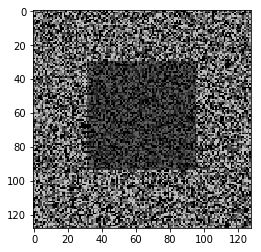

In [4]:
leftTest = cv2.imread('./Data/leftTest.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(leftTest, cmap='gray', vmin = 0, vmax = 255)

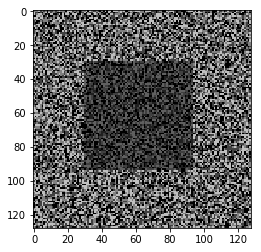

In [5]:
rightTest = cv2.imread('./Data/rightTest.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(rightTest, cmap='gray', vmin = 0, vmax = 255)

In [6]:
#Naive algorithm
#def ssd_template_image(template, image):
#    (tplRows, tplCols) = template.shape
#    s = np.zeros_like(image)
#    
#    for r in range(image.shape[0] - 1):
#        for c in range(image.shape[1] - 1):
#            for j in range(tplRows - 1):
#                for i in range(tplCols - 1):
#                    s[r,c] += (template[j, i] - image[r+j - tplRows/2, c + i - tplRows/2])**2
#    
#    return s

In [7]:
def normalize_255(matrix):
    return ((matrix.astype(np.float32) / np.max(matrix))*255).astype(np.uint8)

In [8]:
def disparity(image1, image2, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 0, disparity_max = 1000):
    if tplRows %2 == 0 or tplCols % 2 == 0:
        raise Exception('Use a symmetric template')
    disparity_max = min(disparity_max, image1.shape[1])
    row_margin = (tplRows - 1)/2 
    col_margin = (tplCols - 1)/2 
    ssd_map = np.zeros_like(image1)
    
    for row in np.arange(row_margin, image1.shape[0] - row_margin):
        for col in np.arange(col_margin, image1.shape[1] - col_margin):
            template = image1[row-row_margin:row+row_margin+1, col-col_margin:col+col_margin+1]
            template = template.astype(np.int32)
            image_bar = image2[row-row_margin:row+row_margin+1,:]
            image_bar = image_bar.astype(np.int32)
            if LefttoRight:
                match_values = np.arange(min(col + disparity_min, image2.shape[1]-col_margin-1), \
                                     min(col + disparity_max+1, image2.shape[1]-col_margin))
            else:
                match_values = np.arange(max(col - disparity_max, col_margin), \
                                         max(col - disparity_min+1, col_margin+1))

            SSDs = [((template - image_bar[:, m-col_margin:m+col_margin+1])**2).sum() for m in match_values]
            if not SSDs:
                continue
                
            ssd_map[row,col] = abs(match_values[np.argmin(SSDs)] - col)
            
    return ssd_map

In [9]:
ltr = disparity(rightTest, leftTest, LefttoRight = True, tplRows = 13, tplCols = 13)
rtl = disparity(leftTest, rightTest, LefttoRight = False, tplRows = 13, tplCols = 13)

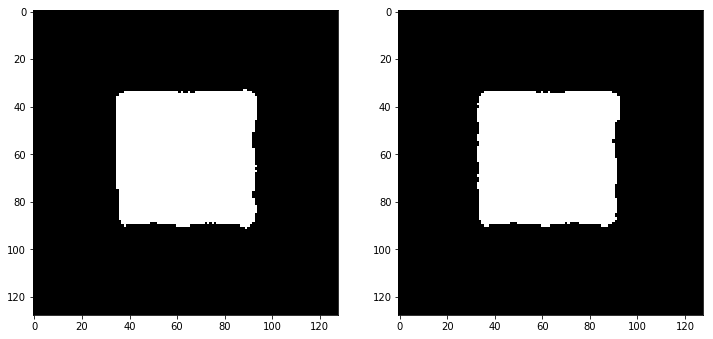

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr), cmap='gray', vmin = 0, vmax = 255)

We can't get interesting results with templates of a size below 13. It is the absolute minimum to get expected white squares in the center of the disparity images, corresponding to a shift of a few pixels (since the bakground isn't shifted). Even so, we get some uncertainty with regards to the actual shape of the square (on the edges), so a better strategy could be to use bigger templates for matching (so that SSD is less sensitive by using more pixels to sum on).

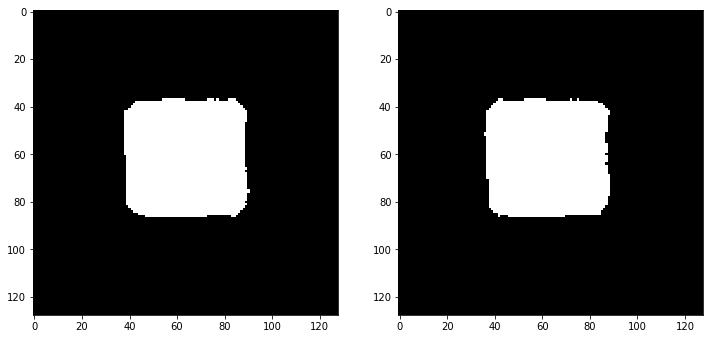

In [11]:
ltr = disparity(rightTest, leftTest, LefttoRight = True, tplRows = 25, tplCols = 25)
rtl = disparity(leftTest, rightTest, LefttoRight = False, tplRows = 25, tplCols = 25)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr), cmap='gray', vmin = 0, vmax = 255)

In the end, it's a compromise: using templates with too low a size results in poor detection of the general figure's disparity (a few pixels on the edge only), but using windows too large for templates results in a smoothed version of the disparity image, where in this case, the borders of the inner square are considered to have a zero disparity.

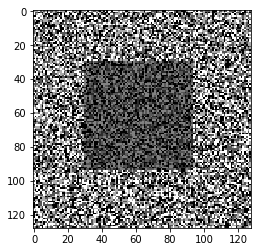

In [12]:
plt.imshow(normalize_255(ltr + rightTest), cmap='gray', vmin = 0, vmax = 255)

# 2. Real images

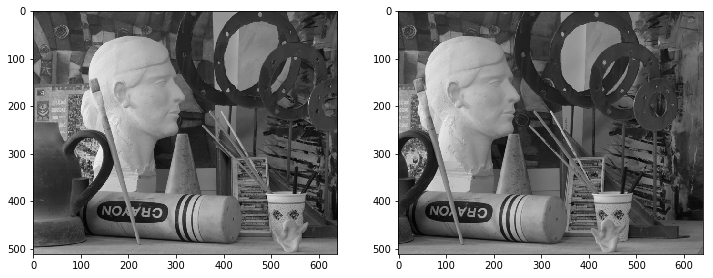

In [13]:
pair1L = cv2.imread('./Data/proj2-pair1-L.png', cv2.IMREAD_GRAYSCALE)
pair1R = cv2.imread('./Data/proj2-pair1-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair1L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair1R, cmap='gray', vmin = 0, vmax = 255)

## 2.a. Disparity algorithm on real images

In order to reduce search time, we can use information from the scene to limit possible values of disparity.  
The (dove-like?) sculpture in the foreground: it is at 526px on the left image, and at 429px on the right image. Therefore the  maximum disparity is expected to be less than 110.  
Edge of the red painting in the background : 378px on the left image, 341px on the right image => minimum disparity expected to  be more than 35.

In [14]:
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)

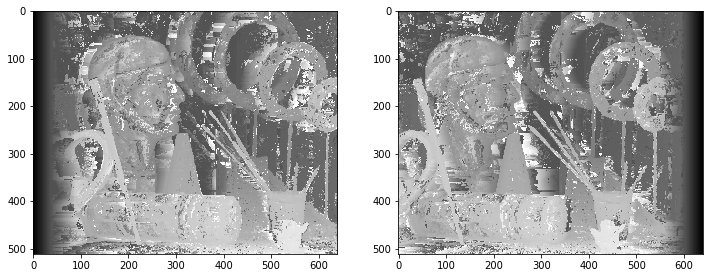

In [15]:
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

On both disparity images, we can notice some noise with white traces sprinkled on darker areas. This corresponds to areas with the (estimated) biggest disparities between left and right images. We can, just like before, try to rely on template matching with bigger windows to attempt to reduce noise:

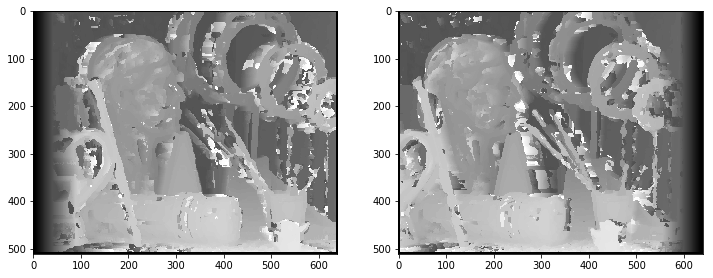

In [16]:
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 9, tplCols = 9, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 9, tplCols = 9, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

As in the previous case, with bigger windows, the shape are less sharp and well defined, but at least white areas (biggest disparities) are more concentrated on specific areas instead of being present a little bit everywhere.

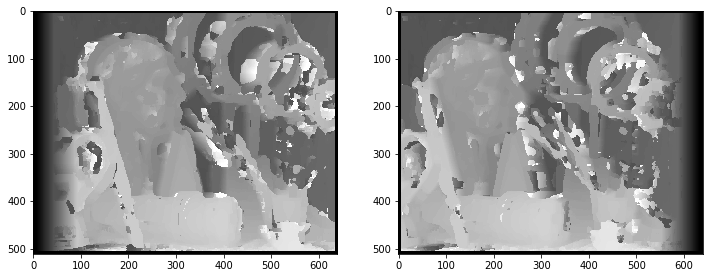

In [17]:
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 15, tplCols = 15, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 15, tplCols = 15, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

Trying even bigger template size, we reach a point where there is no obvious improvement: the shapes get deformed a lot (very true with the brushes in the pot, and the four rings).

## 2.b. Ground truth comparison

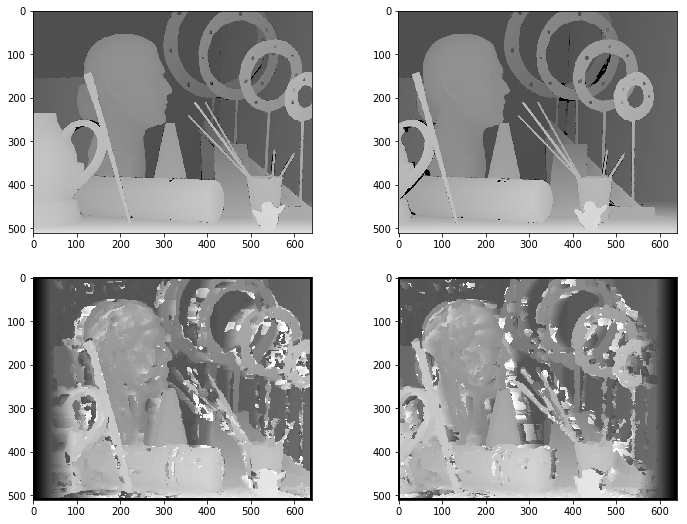

In [45]:
pair1_truth_L = cv2.imread('./Data/proj2-pair1-Disp-L.png', cv2.IMREAD_GRAYSCALE)
pair1_truth_R = cv2.imread('./Data/proj2-pair1-Disp-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair1_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair1_truth_R, cmap='gray', vmin = 0, vmax = 255)
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 9, tplCols = 9, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 9, tplCols = 9, disparity_min = 35, disparity_max = 110)
plt.subplot(2,2,3)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

The SSD match does a pretty good job at identifying the different components of the image at different depths (different values of disparities shown by the grey-intensity differences). We can easily identify the rings, the face, the handle of the pottery, the brushes in the pot, etc. And it manages to retrieve a correct ordering of the shapes as a function of depth in the scene: the closest ring is of a lighter color than those in the back. The (dove-like?) sculpture in the foreground is accurately detected as being closer than the pot of brushes behind it. Overall, the estimated values for disparity remain constant on the surface of each object, which is the ideal behaviour (as long as there is no major cylindrical/spherical shape with curves).  
When it comes to differences, there are the white spots mentioned earlier, corresponding to estimated high values of disparity on the edges between two surfaces. The detection seems "noisy", which is to be expected from the effects of occlusion. Some of the thin supports for the rings are not accurately rendered, possibly due to the size of the window that was chosen for template matching (the bigger the window, the more likely we are to miss small elements). Finally, because of how the algorithm was implemented, there are black bars on the borders and on one side of each image. This is because no values were computed for pixel areas where we wouldn't have had any information to compute disparity in the first place (given the two input images and ranges of possible disparity).

# 3. Influence of perturbations

## 3.a Influence of Gaussian noise

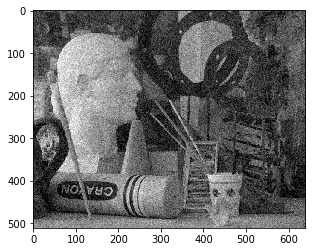

In [19]:
#Adding gaussian noise
sigma = 20

noise = np.zeros_like(pair1R)
noise = np.random.standard_normal(np.shape(pair1R)) * sigma
pair1RNoisy = pair1R + noise
pair1RNoisy[pair1RNoisy < 0] = 0
pair1RNoisy[pair1RNoisy > 255] = 255

plt.imshow(normalize_255(pair1RNoisy), cmap='gray', vmin = 0, vmax = 255)

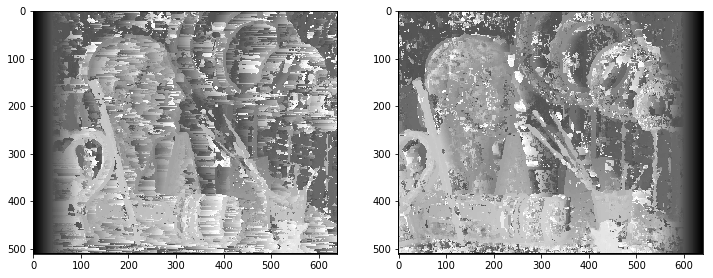

In [20]:
ltr_noise = disparity(pair1RNoisy, pair1L, LefttoRight = True, tplRows = 7, tplCols = 7, disparity_min = 35, disparity_max = 110)
rtl_noise = disparity(pair1L, pair1RNoisy, LefttoRight = False, tplRows = 7, tplCols = 7, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_noise), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_noise), cmap='gray', vmin = 0, vmax = 255)

A less noisy pair of disparity images is given with bigger windows:

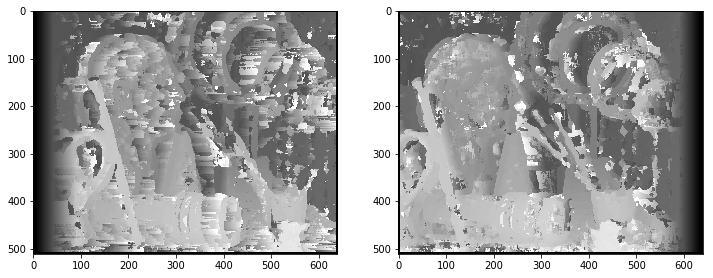

In [21]:
ltr_noise = disparity(pair1RNoisy, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_noise = disparity(pair1L, pair1RNoisy, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_noise), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_noise), cmap='gray', vmin = 0, vmax = 255)

While the second image is more or less the same as the previous (albeit with a bit more noise and white areas, which is to be expected), the first one is very different. The noise translates in the (first) disparity image as some uncertainty. It is most significant on the head sculpture: the estimated disparities take on very different values, with dark and white areas. The same effect can be seen outside of the rings. A trail of lines of various greycale intensities appear next to them.  
Given that only the right image had noise, it follows from this result that it is harder to match templates of a noise-free image on a noisy image than the opposite. Since the implemented algorithm does not use the left-right consistency constraint (primarily for computation time issues), it is to be expected that there might be some asymetrical results in disparity images in this context.

## 3.b. Influence of contrast changes

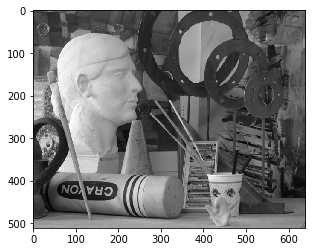

In [22]:
#Increasing contrast
pair1RContrast = pair1R * 1.1
pair1RContrast[pair1RContrast > 255] = 255

plt.imshow(normalize_255(pair1RContrast), cmap='gray', vmin = 0, vmax = 255)

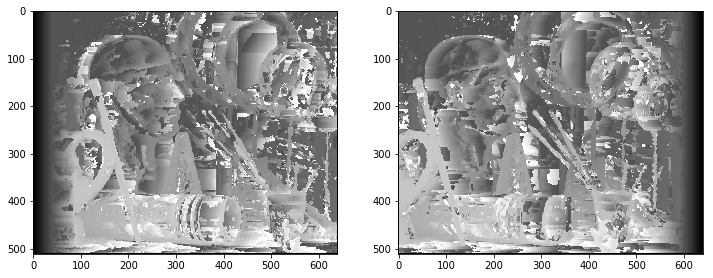

In [23]:
ltr_contrast = disparity(pair1RContrast, pair1L, LefttoRight = True, tplRows = 5, tplCols = 5, disparity_min = 35, disparity_max = 110)
rtl_contrast = disparity(pair1L, pair1RContrast, LefttoRight = False, tplRows = 5, tplCols = 5, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_contrast), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_contrast), cmap='gray', vmin = 0, vmax = 255)

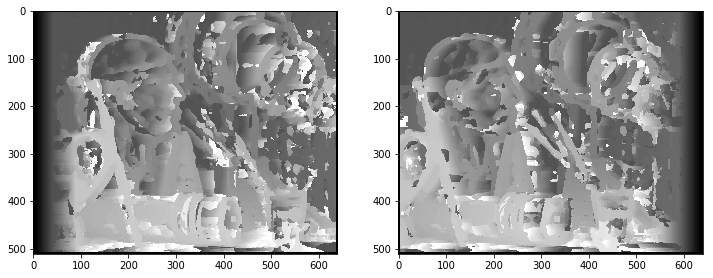

In [24]:
ltr_contrast = disparity(pair1RContrast, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_contrast = disparity(pair1L, pair1RContrast, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_contrast), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_contrast), cmap='gray', vmin = 0, vmax = 255)

While it is still possible to guess most of the shapes and the order of objects with regards to depth is preserved, intensity changes has affected our SSD template matching. In this case, for this change of contrast, it gives us a worse result than with noise applied.  
The head sculpture is this time not uniform at all when it comes to depth, and the shapes of the rings are not well defined. The area around the handle of the sculpture blends with other elements.  
This form of matching relies on the intensities of pixels in a neighborhood, but since we're increasing this intensity (and clipping values above the maximum), it results in a more difficult choice of a corresponding area with minimym SSD along a scanline with multiple candidates (supposedly more similar to one another after this contrast increase and clipping).

# 4. Correlation

## 4.a. Correlation on the original images

In [25]:
def disparity_corr(image1, image2, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 0, disparity_max = 1000):
    if tplRows %2 == 0 or tplCols % 2 == 0:
        raise Exception('Use a symmetric template')
    disparity_max = min(disparity_max, image1.shape[1])
    row_margin = (tplRows - 1)/2 
    col_margin = (tplCols - 1)/2 
    corr_map = np.zeros_like(image1)
    
    for row in np.arange(row_margin, image1.shape[0] - row_margin):
        for col in np.arange(col_margin, image1.shape[1] - col_margin):
            template = image1[row-row_margin:row+row_margin+1, col-col_margin:col+col_margin+1]
            template = template.astype(np.float32)
            image_bar = image2[row-row_margin:row+row_margin+1,:]
            image_bar = image_bar.astype(np.float32)            
            if LefttoRight:
                match_values = np.arange(min(col + disparity_min, image2.shape[1]-col_margin-1), \
                                     min(col + disparity_max+1, image2.shape[1]-col_margin))
            else:
                match_values = np.arange(max(col - disparity_max, col_margin), \
                                         max(col - disparity_min+1, col_margin+1))

            corrs = [cv2.matchTemplate(image_bar[:, m-col_margin:m+col_margin+1], template, method = cv2.TM_CCOEFF_NORMED)[0,0] for m in match_values]
            if not corrs:
                continue

            corr_map[row,col] = abs(match_values[np.argmax(corrs)] - col)

    return corr_map

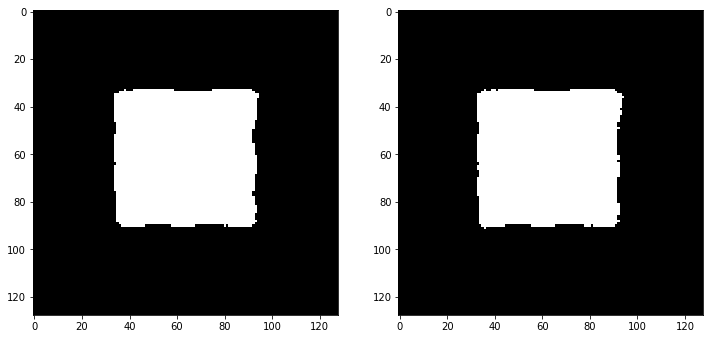

In [26]:
ltr_corr = disparity_corr(rightTest, leftTest, LefttoRight = True, tplRows = 11, tplCols = 11)
rtl_corr = disparity_corr(leftTest, rightTest, LefttoRight = False, tplRows = 11, tplCols = 11)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_corr), cmap='gray', vmin = 0, vmax = 255)

Using OpenCV's normalized correlation function, we can observe more or less the same results on our test images.  
We can apply this alternative matching algorithm to our first pair of stereo images.  
While OpenCV's algorithm and examples used to raise disparities to the power of 3 and renormalize (to accentuate differences in depths), this yielded poor results on pair images and was reverted to the regular form of the algorithm.

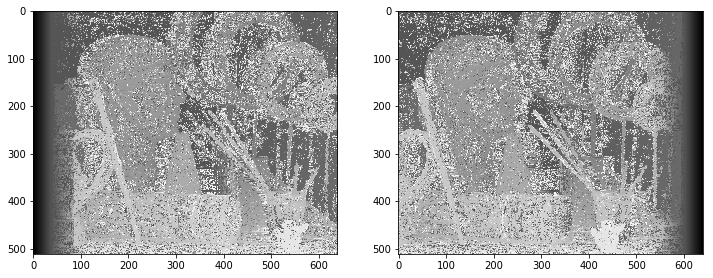

In [27]:
ltr_corr = disparity_corr(pair1R, pair1L, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)
rtl_corr = disparity_corr(pair1L, pair1R, LefttoRight = False, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_corr), cmap='gray', vmin = 0, vmax = 255)

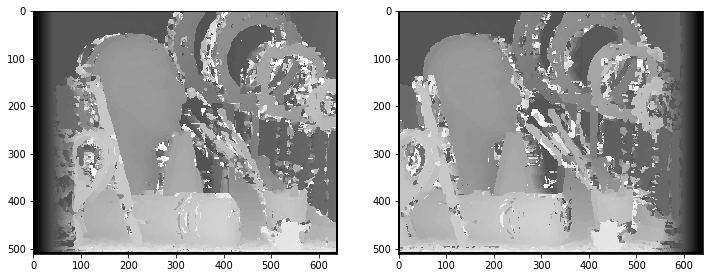

In [28]:
ltr_corr = disparity_corr(pair1R, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_corr = disparity_corr(pair1L, pair1R, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_corr), cmap='gray', vmin = 0, vmax = 255)

In this specific case, correlation does a good job on the original images, just like SSD.  
We can notice however some small differences that might make us prefer SSD: the white areas surrounding edges of objects with different depths are more significant here. Some areas, such as the teapot on the left disparity image have more noise with uncertainty on the depth of the surface.

## 4.b. Correlation on the altered images

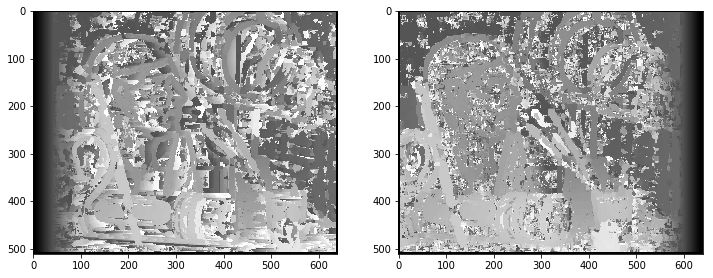

In [29]:
ltr_noise_corr = disparity_corr(pair1RNoisy, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_noise_corr = disparity_corr(pair1L, pair1RNoisy, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_noise_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_noise_corr), cmap='gray', vmin = 0, vmax = 255)

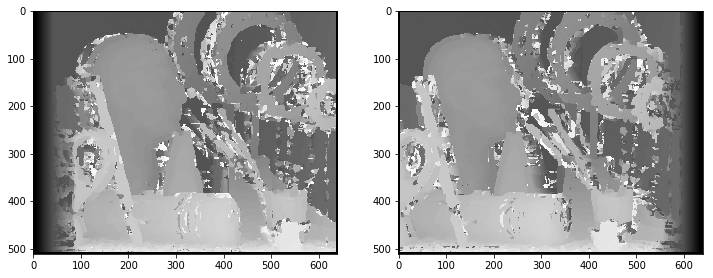

In [30]:
ltr_constrast_corr = disparity_corr(pair1RContrast, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_constrast_corr = disparity_corr(pair1L, pair1RContrast, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_constrast_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_constrast_corr), cmap='gray', vmin = 0, vmax = 255)

Matching with correlation seems to be a poor choice with noisy images. SSD does a significantly better job, while correlation (at least with windows of size 11) gives very noisy disparity images. The one on the left is barely recognizable, but we can still make out some details on the one of the right (shape of the brushes and head). They are overall grainy with weird patterns in the foregroud found to be with the same disparity.  
When it comes to contrast changes, correlation seems to be a lot more robust than SSD. In fact, it is very hard to distinguish any differences in the disparity images generated from the original images and those generated from one that had a change in contrast. As such, we would tend to prefer normalized correlation to SSD if we suspect that there are changes in contrast.

# 5. 2nd pair

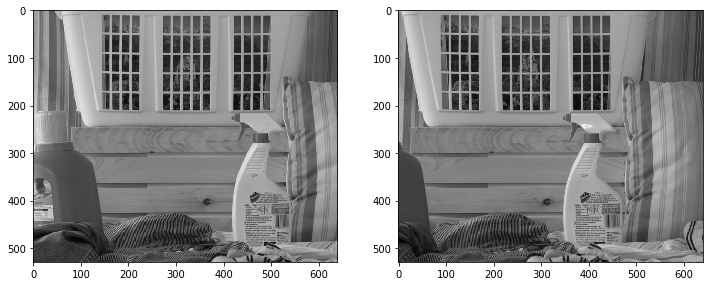

In [31]:
pair2L = cv2.imread('./Data/proj2-pair2-L.png', cv2.IMREAD_GRAYSCALE)
pair2R = cv2.imread('./Data/proj2-pair2-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)

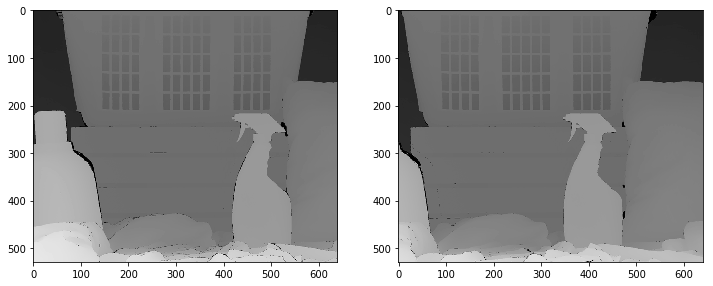

In [32]:
pair2_truth_L = cv2.imread('./Data/proj2-pair2-Disp-L.png', cv2.IMREAD_GRAYSCALE)
pair2_truth_R = cv2.imread('./Data/proj2-pair2-Disp-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)

In [35]:
#@interact(noise = (0,500), contrast = (0,100), template_size = (3,71,2), correlation = False, verbose = False)
def pair2(noise = 0, contrast = 0, correlation = False, template_size = 41, disparity_min = 20, disparity_max = 120, verbose = True):
    pair2L = cv2.imread('./Data/proj2-pair2-L.png', cv2.IMREAD_GRAYSCALE)
    pair2R = cv2.imread('./Data/proj2-pair2-R.png', cv2.IMREAD_GRAYSCALE)
    if verbose: 
        print("Original images")
        plt.figure(figsize=(12, 9))
        plt.subplot(1,2,1)
        plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
        plt.subplot(1,2,2)
        plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

    noise = np.zeros_like(pair2R)
    noiseMat = np.random.standard_normal(np.shape(pair2R)) * noise
    pair2R = pair2R + noiseMat
    pair2R[pair2R < 0] = 0
    pair2R[pair2R > 255] = 255
    
    if verbose: 
        print("Images after applying noise")
        plt.figure(figsize=(12, 9))
        plt.subplot(1,2,1)
        plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
        plt.subplot(1,2,2)
        plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

    pair2R = pair2R * (1 + contrast/100.)
    pair2R[pair2R > 255] = 255

    if verbose: 
        print("Images after applying contrast")
        plt.figure(figsize=(12, 9))
        plt.subplot(1,2,1)
        plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
        plt.subplot(1,2,2)
        plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

    if not correlation:
        pair2ltr = disparity(pair2R, pair2L, LefttoRight = True, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)
        pair2rtl = disparity(pair2L, pair2R, LefttoRight = False, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)
    else:
        pair2ltr = disparity_corr(pair2R, pair2L, LefttoRight = True, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)
        pair2rtl = disparity_corr(pair2L, pair2R, LefttoRight = False, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)

    if verbose:
        print("Disparity with template of size " + str(template_size))
        
    plt.figure(figsize=(12, 9))
    plt.subplot(1,2,1)
    plt.imshow(normalize_255(pair2rtl), cmap='gray', vmin = 0, vmax = 255)
    plt.subplot(1,2,2)
    plt.imshow(normalize_255(pair2ltr), cmap='gray', vmin = 0, vmax = 255)

The following function was used to generate a range of disparity images with regards to the size of the window we use for template matching for the second pair. They were saved (to avoid repeating lenghty computations) and some of the most interesting results are shown below.

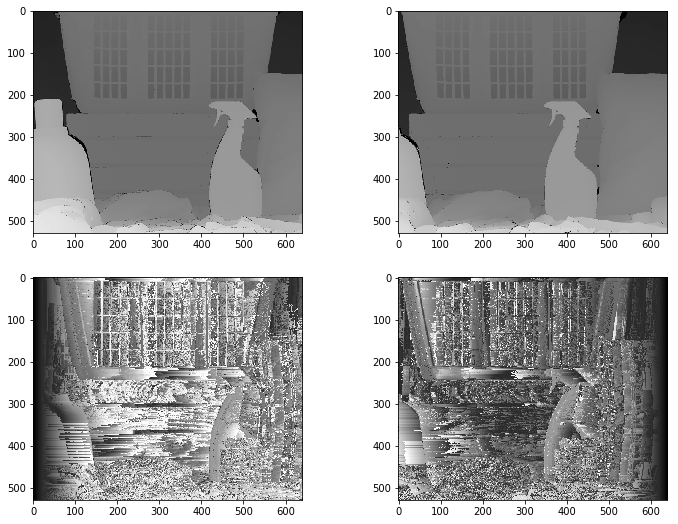

In [36]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/1-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/1-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

We can still get some pretty interesting results with the smallest window (1px on each side of point, i.e. a square window of 9 pixels). In this case there isn't any noise or contrast changes but we get a noisy disparity image that can't accurately describe the depth of the objects of the scene.  
However, this is the best disparity images that accurately capture the lanundry basket, its grid shape and the depth differences inside. For finer elements like this grid, this is the best we can do. 

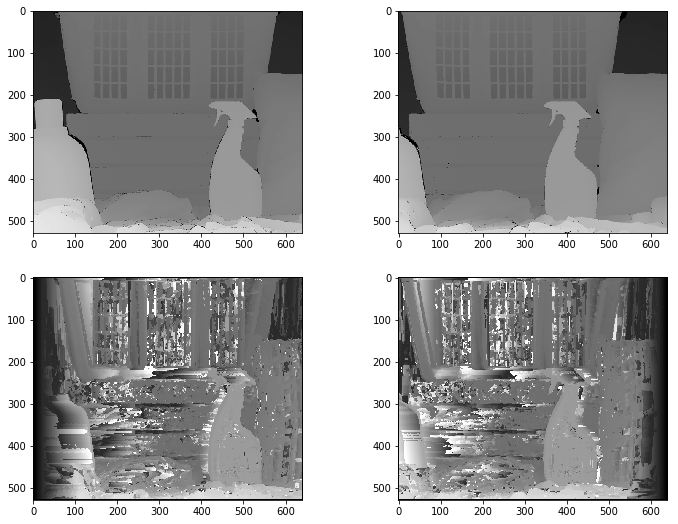

In [37]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/5-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/5-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

With a window of 5px on each side for templates, we get better results with less noisy lines. The basket is still somewhat well detected, just like the spray and the bottle of detergent on the left. We have a somewhat accurate detection of the laundry that lies before the spray (not so much true of the laundry before the detergent bottle).

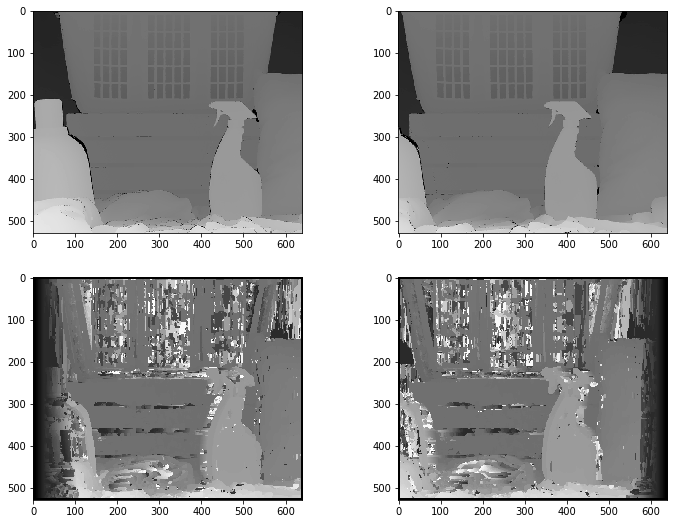

In [38]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/11-corr-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/11-corr-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

Using correlation instead of SSD, we get a good detection of the overall noise-free scene (basket, spray, planks of wood) identified with accurate relative disparities, but the finer details (inside the basket) is poorly identified.

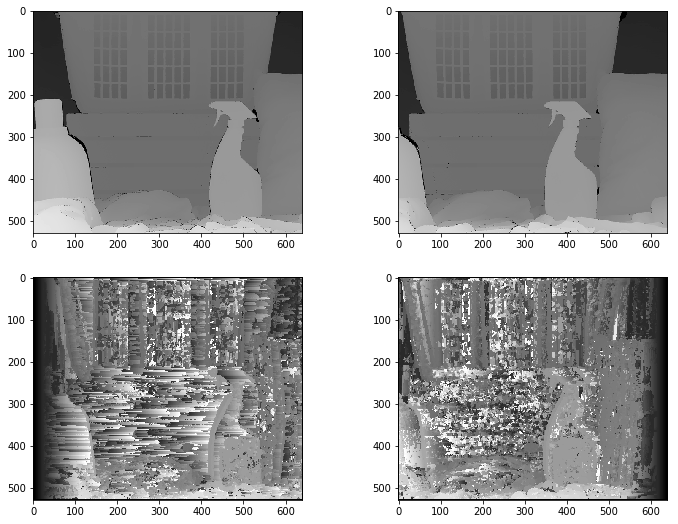

In [39]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Noisy-7-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Noisy-7-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

Adding noise on the right image (same process as with pair 1), we get the same results when it comes to the left disparity map: the noise generates a lot of uncertainty with parallel horizontal lines of various intensity. Aside from the spray, not much can be identified.

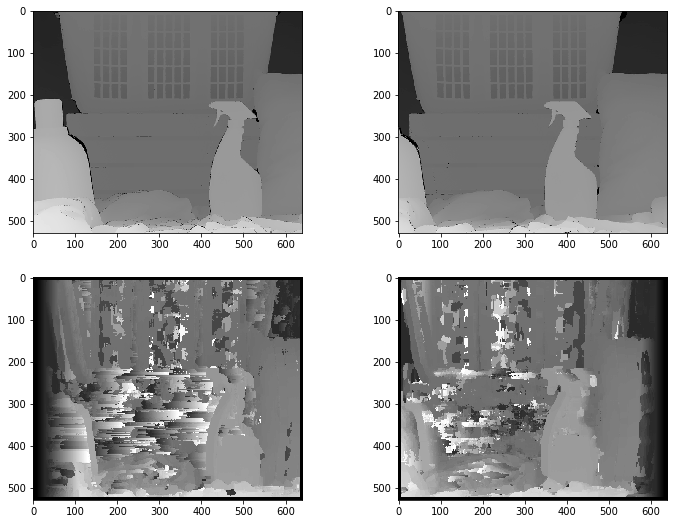

In [40]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Noisy-17-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Noisy-17-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

Of course, we could try increasing the size of the window (17 on each side of the pixel) to compensate for this noise, but it is only marginally better (the basket is somewhat more visible, with the spray identifed as being in front of it).

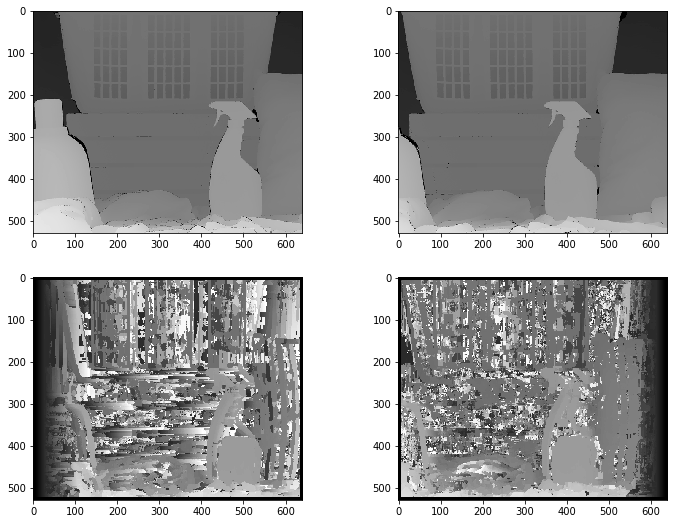

In [41]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Noisy-13-corr-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Noisy-13-corr-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

As expected from the results of pair 1, using correlation does not yield better results on this noisy image from pair 2.

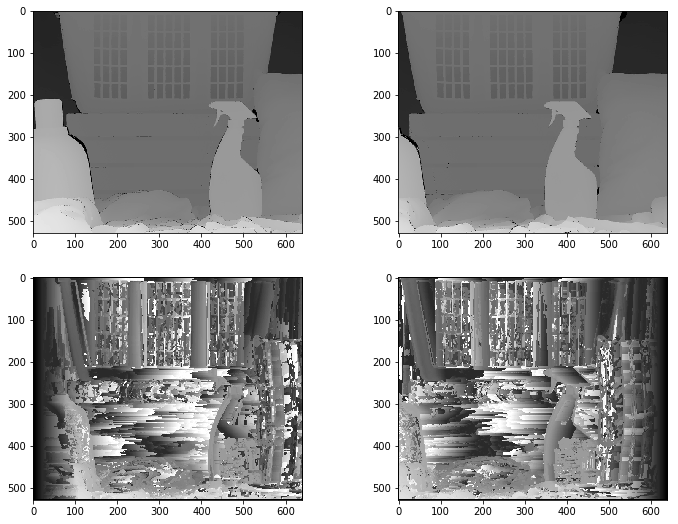

In [42]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Contrast-5-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Contrast-5-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

Having applied contrast changes (10% increase on the right image, with the same process that was used for pair 1), we get poor results and a noisy disparity image using SSD.

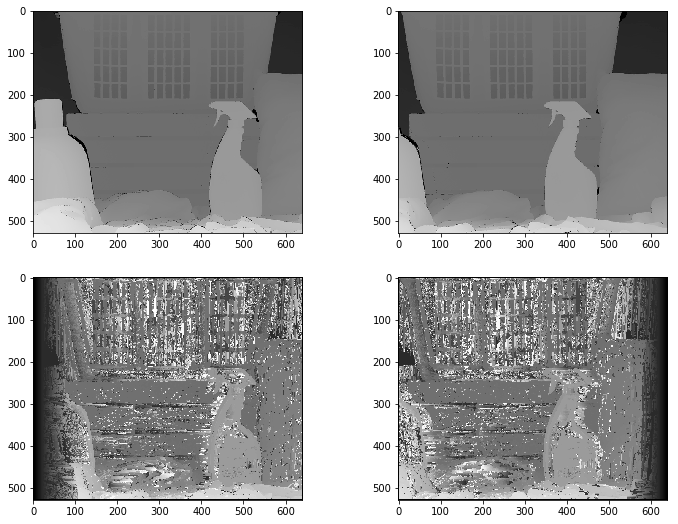

In [43]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Contrast-5-corr-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Contrast-5-corr-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

Just like normalized correlation was a much better choice for pair 1 when the contrast was changed, we get (arguably) much better results in pair 2 compaired to SSD. While there is some noise (sprinkled white dots), the scene is much more closer to the ground truth: the basket, the planks, the bottle and spray as well as the laundry in front of the spray are all accurately represented with correct relative disparity values/depths.  
Unlike with pair 1 however, we can finally notice a significant difference when applying contrast, so correlation is robust but not unaffected by contrast changes.

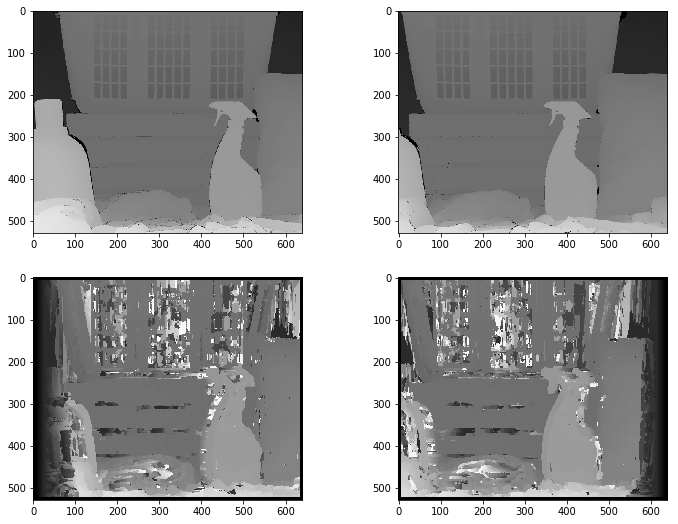

In [44]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Contrast-13-corr-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Contrast-13-corr-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

Increasing the size of the window (still using correlation on contrasted images) helps us get rid of some of the noise, at the expense of an accurate representation of the shapes.